In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Chan 2019-08-20 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.14.0
matplotlib 3.1.0
imblearn 0.5.0


Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle
from utils import morp_preprocessing

# Load datasets

In [3]:
datasets = pd.read_csv('../../data/train.csv', engine='python', encoding='utf-16')
datasets.head()

,Unnamed: 0,comment,url_id,label
0,0,ㅜㅜ,77,0
1,1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,17,0
2,2,헐,52,0
3,3,제시,75,0
4,4,이거인 듯,18,0


In [4]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 4 columns):
Unnamed: 0    42000 non-null int64
comment       42000 non-null object
url_id        42000 non-null int64
label         42000 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [5]:
len(datasets[datasets.label ==1])/ len(datasets) # 유해한 레이블의 데이터가 많이 부족함 데이터 편향ㅠㅠ 

0.0499047619047619

# 형태소분석

In [6]:
morp = Okt()

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [7]:
morped = [morp.morphs(_, norm=True, stem=True) for _ in tqdm(datasets.comment)]
morped[:5]

100%|███████████████████████████████████████████████████████████████████████████| 42000/42000 [01:42<00:00, 742.21it/s]


[['ㅜㅜ'], ['ㅋㅋㅋ'], ['헐다'], ['제시'], ['이', '거인', '듯']]

## Dictionary
최빈 형태소에 대한 단어사전 구성

In [8]:
vocab_size = 30000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

        vocab = {
        '<PAD>': pad_id,
        '<OOV>': oov_id
        }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(morped)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# # vocab save
# with open('./vocab/vocab_index.pickle', 'wb') as f:
#     pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
# with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
#     pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
ㅋㅋㅋ :  7874
? :  3235
이 :  3011
하다 :  2327
! :  1151
ㅋㅋ :  1114
가 :  1020
오다 :  969
아 :  911
이다 :  789

단어 사전:
0 <PAD>
1 <OOV>
2 ㅋㅋㅋ
3 ?
4 이
5 하다
6 !
7 ㅋㅋ
8 가
9 오다

단어 사전 크기:  15600


In [9]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", morped[0])
ids = text_to_index(morped[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['ㅜㅜ']
문자 -> 숫자:  [282]
숫자 -> 문자:  ㅜㅜ


In [10]:
x_variable = [text_to_index(_) for _ in morped]

sentence_size = 10
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

In [11]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [12]:
import warnings
warnings.filterwarnings(action='once')


# 데이터 클래스 불균형 문제 해결하자

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, datasets.label)

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE

In [151]:
up_X, up_y = RandomOverSampler().fit_resample(X_train, y_train)

# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(59872, 29936)

In [152]:
model_up = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 59872 samples, validate on 10500 samples
Epoch 1/5


20320/59872 [=========>....................] - ETA: 1:21:34 - loss: 0.0164 - recall_18: 1.00 - ETA: 16:38 - loss: 0.0710 - recall_18: 0.9875 - ETA: 9:30 - loss: 0.0818 - recall_18: 0.9826 - ETA: 6:43 - loss: 0.0619 - recall_18: 0.985 - ETA: 5:14 - loss: 0.0604 - recall_18: 0.987 - ETA: 4:19 - loss: 0.0588 - recall_18: 0.985 - ETA: 3:41 - loss: 0.0657 - recall_18: 0.982 - ETA: 3:14 - loss: 0.0676 - recall_18: 0.981 - ETA: 2:58 - loss: 0.0677 - recall_18: 0.981 - ETA: 2:47 - loss: 0.0681 - recall_18: 0.980 - ETA: 2:32 - loss: 0.0654 - recall_18: 0.980 - ETA: 2:20 - loss: 0.0690 - recall_18: 0.979 - ETA: 2:10 - loss: 0.0689 - recall_18: 0.980 - ETA: 2:02 - loss: 0.0668 - recall_18: 0.979 - ETA: 1:59 - loss: 0.0650 - recall_18: 0.980 - ETA: 1:52 - loss: 0.0629 - recall_18: 0.981 - ETA: 1:48 - loss: 0.0657 - recall_18: 0.980 - ETA: 1:42 - loss: 0.0637 - recall_18: 0.981 - ETA: 1:38 - loss: 0.0628 - recall_18: 0.981 - ETA: 1:35 - loss: 0.0617 - recall_18: 0.981 - ETA: 1:32 - loss: 0.0602 - r

59872/59872 [==============================] - ETA: 10s - loss: 0.0581 - recall_18: 0.98 - ETA: 10s - loss: 0.0581 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0582 - recall_18: 0.98 - ETA: 10s - loss: 0.0581 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0579 - recall_18: 0.98 - ETA: 10s - loss: 0.0579 - recall_18: 0.98 - ETA: 10s - loss: 0.0579 - recall_18: 0.98 - ETA: 10s - loss: 0.0578 - recall_18: 0.98 - ETA: 9s - loss: 0.0577 - recall_18: 0.9819 - ETA: 9s - loss: 0.0577 - recall_18: 0.981 - ETA: 9s - loss: 0.0579 - recall_18: 0.981 - ETA: 9s - loss: 0.0580 - recall_18: 0.981 - ETA: 9s - loss: 0.0579 - recall_18: 0.981 - ETA: 9s - loss: 0.0580 - rec

21024/59872 [=========>....................] - ETA: 35s - loss: 0.0072 - recall_18: 1.00 - ETA: 29s - loss: 0.0434 - recall_18: 0.98 - ETA: 27s - loss: 0.0341 - recall_18: 0.98 - ETA: 27s - loss: 0.0397 - recall_18: 0.98 - ETA: 26s - loss: 0.0540 - recall_18: 0.97 - ETA: 27s - loss: 0.0525 - recall_18: 0.97 - ETA: 27s - loss: 0.0487 - recall_18: 0.98 - ETA: 26s - loss: 0.0455 - recall_18: 0.98 - ETA: 26s - loss: 0.0527 - recall_18: 0.98 - ETA: 27s - loss: 0.0564 - recall_18: 0.98 - ETA: 27s - loss: 0.0556 - recall_18: 0.98 - ETA: 27s - loss: 0.0560 - recall_18: 0.98 - ETA: 27s - loss: 0.0615 - recall_18: 0.98 - ETA: 27s - loss: 0.0684 - recall_18: 0.98 - ETA: 27s - loss: 0.0669 - recall_18: 0.98 - ETA: 27s - loss: 0.0647 - recall_18: 0.98 - ETA: 27s - loss: 0.0622 - recall_18: 0.98 - ETA: 27s - loss: 0.0644 - recall_18: 0.98 - ETA: 27s - loss: 0.0626 - recall_18: 0.98 - ETA: 27s - loss: 0.0618 - recall_18: 0.98 - ETA: 27s - loss: 0.0593 - recall_18: 0.98 - ETA: 28s - loss: 0.0576 - rec

59872/59872 [==============================] - ETA: 9s - loss: 0.0468 - recall_18: 0.985 - ETA: 9s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 8s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0470 - recall_18: 0.985 - ETA: 8s - loss: 0.0470 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 8s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 7s - loss: 0.0466 - recall_18: 0.985 - ETA: 7s - loss: 0.0466 - recall_18: 0.985 - ETA: 7s - loss: 0.0467 - reca

20736/59872 [=========>....................] - ETA: 41s - loss: 0.0166 - recall_18: 1.00 - ETA: 30s - loss: 0.0279 - recall_18: 0.99 - ETA: 30s - loss: 0.0338 - recall_18: 0.98 - ETA: 30s - loss: 0.0327 - recall_18: 0.98 - ETA: 29s - loss: 0.0286 - recall_18: 0.99 - ETA: 29s - loss: 0.0382 - recall_18: 0.98 - ETA: 29s - loss: 0.0354 - recall_18: 0.98 - ETA: 28s - loss: 0.0325 - recall_18: 0.98 - ETA: 28s - loss: 0.0340 - recall_18: 0.98 - ETA: 28s - loss: 0.0337 - recall_18: 0.98 - ETA: 28s - loss: 0.0370 - recall_18: 0.98 - ETA: 28s - loss: 0.0356 - recall_18: 0.98 - ETA: 28s - loss: 0.0344 - recall_18: 0.98 - ETA: 28s - loss: 0.0380 - recall_18: 0.98 - ETA: 28s - loss: 0.0379 - recall_18: 0.98 - ETA: 28s - loss: 0.0405 - recall_18: 0.98 - ETA: 29s - loss: 0.0404 - recall_18: 0.98 - ETA: 29s - loss: 0.0408 - recall_18: 0.98 - ETA: 30s - loss: 0.0402 - recall_18: 0.98 - ETA: 29s - loss: 0.0399 - recall_18: 0.98 - ETA: 29s - loss: 0.0401 - recall_18: 0.98 - ETA: 29s - loss: 0.0395 - rec

59872/59872 [==============================] - ETA: 9s - loss: 0.0445 - recall_18: 0.9860 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.985 - ETA: 9s - loss: 0.0447 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0445 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0444 - recall_18: 0.986 - ETA: 9s - loss: 0.0444 - recall_18: 0.986 - ETA: 9s - loss: 0.0444 - recall_18: 0.986 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0444 - rec

18944/59872 [========>.....................] - ETA: 52s - loss: 0.0042 - recall_18: 1.00 - ETA: 32s - loss: 0.0878 - recall_18: 0.96 - ETA: 32s - loss: 0.0706 - recall_18: 0.97 - ETA: 32s - loss: 0.0615 - recall_18: 0.97 - ETA: 32s - loss: 0.0565 - recall_18: 0.97 - ETA: 34s - loss: 0.0497 - recall_18: 0.97 - ETA: 35s - loss: 0.0531 - recall_18: 0.97 - ETA: 35s - loss: 0.0521 - recall_18: 0.97 - ETA: 36s - loss: 0.0477 - recall_18: 0.97 - ETA: 36s - loss: 0.0491 - recall_18: 0.97 - ETA: 36s - loss: 0.0469 - recall_18: 0.97 - ETA: 37s - loss: 0.0446 - recall_18: 0.98 - ETA: 37s - loss: 0.0421 - recall_18: 0.98 - ETA: 37s - loss: 0.0409 - recall_18: 0.98 - ETA: 39s - loss: 0.0436 - recall_18: 0.98 - ETA: 39s - loss: 0.0431 - recall_18: 0.98 - ETA: 38s - loss: 0.0408 - recall_18: 0.98 - ETA: 39s - loss: 0.0410 - recall_18: 0.98 - ETA: 39s - loss: 0.0430 - recall_18: 0.98 - ETA: 39s - loss: 0.0413 - recall_18: 0.98 - ETA: 39s - loss: 0.0414 - recall_18: 0.98 - ETA: 39s - loss: 0.0425 - rec

59872/59872 [==============================] - ETA: 9s - loss: 0.0423 - recall_18: 0.986 - ETA: 9s - loss: 0.0423 - recall_18: 0.987 - ETA: 9s - loss: 0.0423 - recall_18: 0.986 - ETA: 8s - loss: 0.0424 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0426 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0426 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0426 - recall_18: 0.986 - ETA: 8s - loss: 0.0427 - recall_18: 0.986 - ETA: 8s - loss: 0.0427 - recall_18: 0.986 - ETA: 8s - loss: 0.0426 - recall_18: 0.986 - ETA: 8s - loss: 0.0427 - recall_18: 0.986 - ETA: 8s - loss: 0.0429 - recall_18: 0.986 - ETA: 8s - loss: 0.0428 - recall_18: 0.986 - ETA: 7s - loss: 0.0428 - recall_18: 0.986 - ETA: 7s - loss: 0.0428 - recall_18: 0.986 - ETA: 7s - loss: 0.0427 - recall_18: 0.986 - ETA: 7s - loss: 0.0428 - reca

23264/59872 [==========>...................] - ETA: 42s - loss: 0.0582 - recall_18: 0.96 - ETA: 28s - loss: 0.0435 - recall_18: 0.97 - ETA: 27s - loss: 0.0416 - recall_18: 0.98 - ETA: 27s - loss: 0.0387 - recall_18: 0.98 - ETA: 28s - loss: 0.0451 - recall_18: 0.98 - ETA: 29s - loss: 0.0463 - recall_18: 0.98 - ETA: 28s - loss: 0.0427 - recall_18: 0.98 - ETA: 28s - loss: 0.0427 - recall_18: 0.98 - ETA: 28s - loss: 0.0394 - recall_18: 0.98 - ETA: 27s - loss: 0.0390 - recall_18: 0.98 - ETA: 27s - loss: 0.0371 - recall_18: 0.98 - ETA: 27s - loss: 0.0368 - recall_18: 0.98 - ETA: 27s - loss: 0.0356 - recall_18: 0.98 - ETA: 27s - loss: 0.0338 - recall_18: 0.98 - ETA: 27s - loss: 0.0325 - recall_18: 0.98 - ETA: 27s - loss: 0.0328 - recall_18: 0.98 - ETA: 27s - loss: 0.0318 - recall_18: 0.98 - ETA: 27s - loss: 0.0348 - recall_18: 0.98 - ETA: 27s - loss: 0.0336 - recall_18: 0.98 - ETA: 27s - loss: 0.0365 - recall_18: 0.98 - ETA: 27s - loss: 0.0364 - recall_18: 0.98 - ETA: 27s - loss: 0.0389 - rec

10500/10500 [==============================] - ETA: 1s - loss: 0.5221 - recall_18: 0.968 - ETA: 1s - loss: 0.8983 - recall_18: 0.917 - ETA: 1s - loss: 0.6966 - recall_18: 0.925 - ETA: 1s - loss: 0.6369 - recall_18: 0.929 - ETA: 1s - loss: 0.6423 - recall_18: 0.925 - ETA: 1s - loss: 0.6342 - recall_18: 0.926 - ETA: 1s - loss: 0.6171 - recall_18: 0.924 - ETA: 1s - loss: 0.5895 - recall_18: 0.925 - ETA: 1s - loss: 0.5935 - recall_18: 0.923 - ETA: 1s - loss: 0.5946 - recall_18: 0.923 - ETA: 1s - loss: 0.5659 - recall_18: 0.926 - ETA: 0s - loss: 0.5680 - recall_18: 0.926 - ETA: 0s - loss: 0.5693 - recall_18: 0.927 - ETA: 0s - loss: 0.5630 - recall_18: 0.928 - ETA: 0s - loss: 0.5524 - recall_18: 0.928 - ETA: 0s - loss: 0.5491 - recall_18: 0.928 - ETA: 0s - loss: 0.5404 - recall_18: 0.929 - ETA: 0s - loss: 0.5340 - recall_18: 0.930 - ETA: 0s - loss: 0.5288 - recall_18: 0.930 - ETA: 0s - loss: 0.5308 - recall_18: 0.929 - ETA: 0s - loss: 0.5314 - recall_18: 0.930 - ETA: 0s - loss: 0.5253 - reca

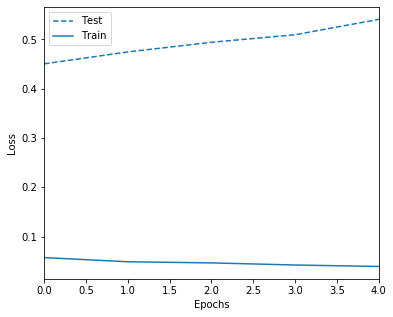

In [154]:
model_up.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_up.fit(up_X,
          pd.get_dummies(up_y),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_up.evaluate(X_test, pd.get_dummies(y_test))
print('Test accuracy:', test_acc)

In [155]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, X_test))
result['predict'] = model_up.predict_proba(X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = y_test

전체채팅수10500, 유해채팅수625


### Recall

In [19]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

In [159]:
recall_score(y_test, model_up.predict_classes(X_test)),\
accuracy_score(y_test, model_up.predict_classes(X_test)),\
f1_score(y_test, model_up.predict_classes(X_test))

(0.40225563909774437, 0.9306666666666666, 0.3702422145328719)

In [158]:
model_up.save('../model/cnn_oversample.h5')

## Downsampling

In [15]:
down_X, down_y = RandomUnderSampler().fit_resample(X_train, y_train)

# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(3146, 1573)

In [16]:
model_down = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu,),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

W0820 20:09:58.924571 11736 deprecation.py:506] From C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 20:09:58.932556 11736 deprecation.py:506] From C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from

W0820 20:09:59.934979 11736 deprecation.py:323] From C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3146 samples, validate on 10500 samples
Epoch 1/5
3146/3146 [==============================] - ETA: 1:31 - loss: 0.6885 - recall: 0.53 - ETA: 23s - loss: 0.6912 - recall: 0.3516 - ETA: 13s - loss: 0.6933 - recall: 0.312 - ETA: 8s - loss: 0.6932 - recall: 0.329 - ETA: 7s - loss: 0.6928 - recall: 0.34 - ETA: 5s - loss: 0.6925 - recall: 0.35 - ETA: 5s - loss: 0.6928 - recall: 0.35 - ETA: 4s - loss: 0.6924 - recall: 0.37 - ETA: 3s - loss: 0.6924 - recall: 0.38 - ETA: 3s - loss: 0.6920 - recall: 0.39 - ETA: 2s - loss: 0.6922 - recall: 0.39 - ETA: 2s - loss: 0.6921 - recall: 0.40 - ETA: 2s - loss: 0.6925 - recall: 0.40 - ETA: 1s - loss: 0.6924 - recall: 0.41 - ETA: 1s - loss: 0.6922 - recall: 0.41 - ETA: 1s - loss: 0.6921 - recall: 0.42 - ETA: 1s - loss: 0.6923 - recall: 0.43 - ETA: 1s - loss: 0.6921 - recall: 0.43 - ETA: 0s - loss: 0.6919 - recall: 0.44 - ETA: 0s - loss: 0.6916 - recall: 0.44 - ETA: 0s - loss: 0.6914 - recall: 0.45 - ETA: 0s - loss: 0.6914 - recall: 0.45 - ETA: 0s 

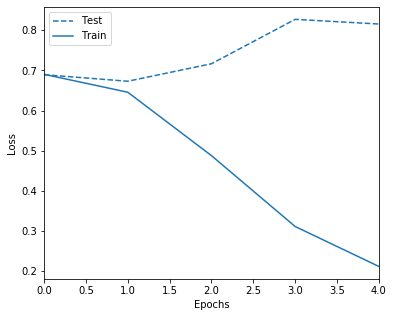

In [17]:
model_down.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_down.fit(down_X,
          pd.get_dummies(down_y),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_down.evaluate(X_test, pd.get_dummies(y_test))
print('Test Recall:', test_acc)

In [20]:
#recall
recall_score(y_test, model_down.predict_classes(X_test)), \
accuracy_score(y_test, model_down.predict_classes(X_test)),\
f1_score(y_test, model_down.predict_classes(X_test))

(0.7839388145315488, 0.7394285714285714, 0.2305961754780652)

In [ ]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, X_test))
result['predict'] = model_down.predict_proba(X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = y_test

## 모델 체크포인트 저장

In [142]:
# model_down.save('../model/cnn_undersample.h5')

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용